<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/dsviz/W&B_Dataset_and_Predictions_Viz_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{dviz-segmentation} -->

<img src="https://i.imgur.com/gb6B4ig.png" width="400" alt="Weights & Biases" />
<!--- @wandbcode{dviz-segmentation} -->

_W&B Datasets & Predictions is currently in the early-access phase. You can use it in our production service at [wandb.ai](https://wandb.ai), with [some limitations](https://docs.wandb.com/datasets-and-predictions#current-limitations). APIs are subject to change. We'd love to hear questions, comments, and ideas! Drop us a line at feedback@wandb.com._

# W&B Dataset Visualization Demo

This notebook demonstrates W&B's dataset visualization features. In particular we show how [W&B Artifacts](https://docs.wandb.com/artifacts) help visualize datasets and predictions, focusing on image data. We track model and data lineage and perform interactive  analysis on the resulting datasets. The overall flow will be:

1. Create a dataset
2. Split the dataset into "train" and "test"
3. Train a model on the "train" dataset
4. Load the trained model and log predictions on both datasets
5. Analyze the results in W&B's UI

You can see live interactive examples logged to W&B in this public project: [Dsviz Demo](https://wandb.ai/stacey/dsviz-demo).

### Explore your training data
<img src="https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/overview_data_table.png" width=600 height=300>

### Visualize your model predictions
<img src="https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/overview_val_predictions.png" width=500 height=300>






# Step 0: Setup

## Install requirements & utils

For brevity, we put utility functions for working with the dataset in `util.py`.

In [1]:
# # Download a util file of helper methods for this notebook
# !curl https://raw.githubusercontent.com/staceysv/dsviz-demo/master/util.py --output util.py

In [2]:
!rm -rf DATA

In [3]:
from fastai.vision.all import *
import wandb
print(wandb.__version__)

0.13.2


## Login to wandb


In [4]:
WANDB_PROJECT = "BDD100k"

Set SIZE to "TINY", "MEDIUM" or (read the warning) "LARGE" to select one of these datasets
- TINY dataset: 50 images
- MEDIUM dataset: 200 images
- LARGE dataset: 400 images 
> warning: you may run out of RAM in Colab & need to restart the notebook between steps at this size

In [5]:
BDD_CLASSES = {i:c for i,c in enumerate(['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
    'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'void'
])}

In [6]:
BDD_CLASSES

{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 19: 'void'}

In [7]:
URL = "https://storage.googleapis.com/wandb_datasets/BDD100K_seg_demo.zip"

SIZE = "TINY"
PREFIX = "bdd"

if SIZE == "TINY":
    NUM_EXAMPLES = 60
    SPLITS = {"train" : 40, "valid":10, "test" : 10}
elif SIZE == "MEDIUM":
    NUM_EXAMPLES = 240
    SPLITS = {"train" : 160,"valid":40,  "test" : 40}
elif SIZE == "LARGE": 
    NUM_EXAMPLES = 480
    SPLITS = {"train" : 320,"valid":80, "test" : 80}

# set global Artifact names (allowing steps to be rerun independently)
RAW_DATA_AT = "_".join([PREFIX, "raw_data", str(NUM_EXAMPLES)])
TRAIN_DATA_AT = "_".join([PREFIX, "train_data", str(NUM_EXAMPLES)])
TEST_DATA_AT = "_".join([PREFIX, "test_data", str(NUM_EXAMPLES)])
SPLIT_DATA_AT = "_".join([PREFIX, "split_data", str(NUM_EXAMPLES)])
LOCAL_TRAIN_DIR = Path("DATA")

In [8]:
RAW_DATA_AT, TRAIN_DATA_AT, TEST_DATA_AT

('bdd_raw_data_60', 'bdd_train_data_60', 'bdd_test_data_60')

## Download the data

Before we get started, we will download an example dataset to our local machine. This is a big dataset (958MB) so please be patient if you are on a slow connection. we will use fastai's `untar_data` function to download and decompress our dataset.

In [9]:
path = untar_data(URL)

we have 2 folders, one with RGB images and one with labels:

In [10]:
path.ls()

(#2) [Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images'),Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels')]

In [11]:
fnames = get_image_files(path/"images")

In [12]:
labels = get_image_files(path/"labels")

In [13]:
fnames[0], labels[0]

(Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images/train/baa79505-43ff4345.jpg'),
 Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels/train/1a92b5b9-87a40001_train_id.png'))

In [14]:
fname = fnames[0]

Let's create a helper function in the `Path` class

In [15]:
@patch
def with_custom_suffix(self: Path, suffix):
    return self.parent/(self.name.split(".")[0] + suffix)

In [16]:
fname.with_custom_suffix("_train_id.png")

Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/images/train/baa79505-43ff4345_train_id.png')

## Show some example training images

In [17]:
def _label_func(fname):
    "Get the corresponding label"
    dataset_path = fname.parent.parent.parent
    train_valid = fname.parent.name
    return ((dataset_path/"labels")/train_valid)/(fname.with_custom_suffix("_train_id.png")).name

In [18]:
_label_func(fname)

Path('/home/tcapelle/.fastai/data/BDD100K_seg_demo/labels/train/baa79505-43ff4345_train_id.png')

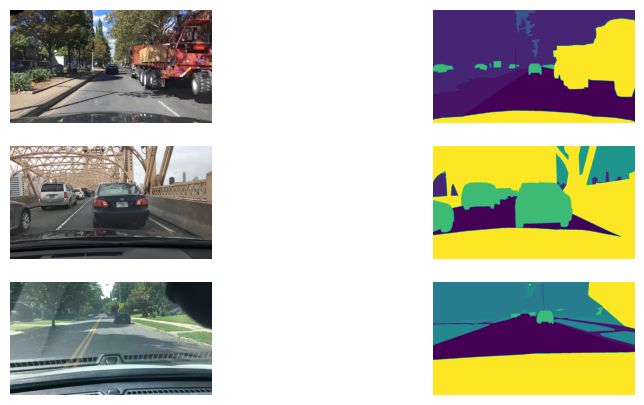

In [19]:
axes = subplots(3, 2, figsize=(10,5))[1]
for fname, ax in zip(fnames, axes):
    label = _label_func(fname)
    pil_img, pil_lbl = load_image(fname), load_image(label)
    show_image(pil_img, ax=ax[0])
    show_image(pil_lbl, ax=ax[1])

# Step 1: Build the dataset

First, let's build a dataset for use in the rest of this project using a `wandb.Run`. A `Run` is an isolated process which can optionally depend on upstream artifacts as well as optionally produce artifacts for later consumption. In this step, we will create a `wandb.Table` during our run and output it in an artifact. This table will contain all of our raw data for later use. W&B also offers rich tools to analyze and visualize such Tables in an interactive UI.

[See a live example of the raw dataset in W&B](https://wandb.ai/stacey/dsviz-demo/artifacts/raw_data/bdd_raw_data_500/afcb923f719b14370215/files/raw_examples.table.json)

> Another option here Darek is to create a new version with Train/Valid/Test

In [20]:
def setup_local_data():
    LOCAL_TRAIN_DIR.mkdir(exist_ok=True)
    (LOCAL_TRAIN_DIR/"images").mkdir(exist_ok=True)
    (LOCAL_TRAIN_DIR/"labels").mkdir(exist_ok=True)

In [21]:
def copy_sample_data(k=NUM_EXAMPLES):
    setup_local_data()
    "Creates a local version of the sample dataset"
    sample_fnames = random.sample(fnames, k=k)
    sample_labels = [_label_func(f) for f in sample_fnames]
    
    # copy images and labels
    for f in sample_fnames:
        shutil.copy(f, LOCAL_TRAIN_DIR/f"images/{f.name}")
    for l in sample_labels:
        shutil.copy(l, LOCAL_TRAIN_DIR/f"labels/{l.name}")

In [22]:
copy_sample_data()

In [23]:
def label_func(fname):
    return (fname.parent.parent/"labels")/(fname.with_custom_suffix("_train_id.png")).name

In [24]:
def get_frequency_distribution(mask_data, class_labels):
    (unique, counts) = np.unique(mask_data, return_counts=True)
    unique = list(unique)
    counts = list(counts)
    frequency_dict = {}
    for _class in class_labels.keys():
        if _class in unique:
            frequency_dict[class_labels[_class]] = counts[unique.index(_class)]
        else:
            frequency_dict[class_labels[_class]] = 0
    return frequency_dict

Maybe we should also log the data as files here

In [25]:
def _create_table(image_files, class_labels):
    "Create a table with the dataset"
    labels = [str(class_labels[_lab]) for _lab in list(class_labels)]
    table = wandb.Table(columns=["File_Name", "Images"] + labels)
    
    for i, image_file in progress_bar(enumerate(image_files), total=len(image_files)):
        image = Image.open(image_file)
        mask_data = np.array(Image.open(label_func(image_file)))
        frequency_distribution = get_frequency_distribution(mask_data, BDD_CLASSES)
        table.add_data(
            str(image_file.name),
            wandb.Image(
                    image,
                    masks={
                        "predictions": {
                            "mask_data": mask_data,
                            "class_labels": class_labels,
                        }
                    }
            ),
            *[frequency_distribution[_lab] for _lab in labels]
        )
    
    return table

In [26]:
image_files = get_image_files(LOCAL_TRAIN_DIR/"images", recurse=False)
_create_table(image_files, BDD_CLASSES)

In [27]:
def log_dataset(project: str, entity: str, path, class_labels):
    with wandb.init(
        project=project, 
        name="log_bdd100k_sample", 
        entity=entity, 
        job_type="log_dataset"
    ):
        table_data = []
        labels = [str(class_labels[_lab]) for _lab in list(class_labels)]
        
        image_files = get_image_files(path/"images", recurse=False)
        
        artifact = wandb.Artifact(name=RAW_DATA_AT, 
                                  type="raw_data",
                                  metadata={"classes":class_labels, 
                                            "num_examples":NUM_EXAMPLES},
                                  description="A Sample of the BDD100k Dataset",
                                 )
        
        print("Add data")
        artifact.add_dir(path)
        
        print("Creating Table...")
        table = _create_table(image_files, class_labels)
        
        
        artifact.add(table, "raw_examples")
        wandb.log_artifact(artifact)
        
        #log to workspace
        wandb.log({"raw_examples":table})

In [28]:
log_dataset(WANDB_PROJECT, None, LOCAL_TRAIN_DIR, BDD_CLASSES)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: capecape. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (./DATA)... Done. 0.1s


Add data
Creating Table...


# Step 2: Splitting the data into train and test

Next, we will split the data into a train and a test dataset. Similar to before, we will launch a `Run` to perform this operation. Remember, this new execution could happen on a different machine as we will dynamically load the needed resources. In particular, we will load in the raw dataset from the last run and split it into 2 new datasets.

See live examples of the [train data](https://wandb.ai/stacey/dsviz-segment/artifacts/train_data/bdd_train_data_200/4bb038903e618f8e0e49) and [test data](https://wandb.ai/stacey/dsviz-segment/artifacts/test_data/bdd_test_data_200/1d6aae785ea663167c82) artifacts in W&B.

### Option 1 as Tables:


Example Data row
 ['6f995cc3-c7d16d56.jpg', <wandb.sdk.data_types.image.Image object at 0x7efca4d45720>, 216203, 0, 196276, 0, 0, 0, 0, 0, 192030, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 317091]

Example Image


Artifact Directory Contents: 
 ['bdd_train_data_60:v0', 'bdd_raw_data_60:v4', 'bdd_split_data_60:v1', 'bdd_raw_data_60:v3', 'bdd_raw_data_50:v2', 'bdd_raw_data_60:v2', 'bdd_raw_data_60:v1']
Saving data to WandB...


... Run Complete


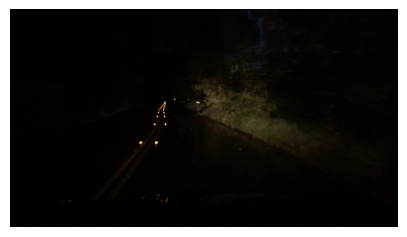

In [29]:
# Initialize a run (you can use the job_type to better organize runs)
run = wandb.init(project=WANDB_PROJECT, job_type="data_split")

# Get the latest version of the artifact. 
# Notice the name alias follows this convention: "<ARTIFACT_NAME>:<VERSION>"
# When version is set to "latest", then the latest version will always be used.
# However, you can pin to a version by using an alias such as "raw_data:v0"
data_at = run.use_artifact(RAW_DATA_AT + ":latest")
    
# Next, we .get the table by the same name that we saved it in the last run.
data_table = data_at.get("raw_examples")
    
# Print a row
print("\nExample Data row\n", data_table.data[0])
    
# Show an example image
print("\nExample Image\n")
show_image(data_table.data[0][1].image)
    
# Notice that a new directory was made: artifacts which is managed by wandb
print("\nArtifact Directory Contents: \n", os.listdir("artifacts"))

# Now we can build two separate artifacts for later use. We will first split the raw table into two parts,
# then create two different artifacts, each of which will hold our new tables. We create two artifacts so that
# in future runs, we can selectively decide which subsets of data to download.
train_table = wandb.Table(columns=data_table.columns, data=data_table.data[:SPLITS["train"]])
test_table = wandb.Table(columns=data_table.columns, data=data_table.data[SPLITS["train"]:])

train_artifact = wandb.Artifact(TRAIN_DATA_AT, "train_data")
test_artifact = wandb.Artifact(TEST_DATA_AT, "test_data")

# Save the tables to the artifacts with .add
train_artifact.add(train_table, "train_table")
# Note: technically our test data has ground truth labels in this example :)
# we could modify this table to remove the labels
test_artifact.add(test_table, "test_table")

# Log the artifacts out as outputs of the run
print("Saving data to WandB...")
run.log_artifact(train_artifact)
run.log_artifact(test_artifact)
run.finish()
print("... Run Complete")

### Review the splits in the Dashboard
Notice, in this step, the raw_data `wandb.Table` was reinstatiated and the data, images, etc... came along for the ride. This makes it easy for ML practitioners on a team to share data and assets easily. To manage this, you can see that we created an artifacts directory to save local data.

Now we have two new datasets. Feel free to browse them similar to our last step. However, this time, click "Graph View" rather than "Files" to see the lineage of the artifact.

Naming and typing in Artifacts are powerful and flexible. In this case, we include a short prefix ("bdd" for Berkeley Deep Drive 100K) and the count of items in each artifact name so that these artifacts are easier to identify and track when viewed at a glance, downloaded locally, or compared to the many other versions we may create in this project (with different total counts, data split strategies, etc).

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/split_train_test.png)

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/test_data_graph.png)

We will come back to this graph view later on!

### Option 2: as CSV, what we did on the course
This is probably done better using some sklearn package like `StratifiedGroupKFold`

In [30]:
sample_fnames = get_image_files(LOCAL_TRAIN_DIR/"images")
sample_labels = [label_func(f) for f in sample_fnames]

In [31]:
df = pd.DataFrame(index=range(SPLITS["train"]), columns=["image_fname","label_fname", "split"])

def assign_split(i):
    "Very un-orthodox"
    if i < SPLITS["train"]: return "train"
    if i < SPLITS["train"]+SPLITS["valid"]: return "valid"
    if i < SPLITS["train"]+SPLITS["valid"]+SPLITS["test"]:  return "test"

In [32]:
for i, (img, lbl) in enumerate(zip(sample_fnames, sample_labels)):
    df.loc[i] = img.relative_to(LOCAL_TRAIN_DIR), lbl.relative_to(LOCAL_TRAIN_DIR), assign_split(i)

In [33]:
df

,image_fname,label_fname,split
0,images/6f995cc3-c7d16d56.jpg,labels/6f995cc3-c7d16d56_train_id.png,train
1,images/6b9077b7-e6a07c88.jpg,labels/6b9077b7-e6a07c88_train_id.png,train
2,images/00e9be89-00001580.jpg,labels/00e9be89-00001580_train_id.png,train
3,images/374088b9-49066168.jpg,labels/374088b9-49066168_train_id.png,train
4,images/a6b971ba-00000000.jpg,labels/a6b971ba-00000000_train_id.png,train
5,images/286f1006-c3b30000.jpg,labels/286f1006-c3b30000_train_id.png,train
6,images/00e9be89-00001050.jpg,labels/00e9be89-00001050_train_id.png,train
7,images/1f607426-1bc0137f.jpg,labels/1f607426-1bc0137f_train_id.png,train
8,images/1d241258-a3b2237d.jpg,labels/1d241258-a3b2237d_train_id.png,train
9,images/c3593016-ac7c536a.jpg,labels/c3593016-ac7c536a_train_id.png,train


In [34]:
df.to_csv('data_split.csv', index=False)

In [35]:
run = wandb.init(project=WANDB_PROJECT, job_type="data_split")

In [36]:
run.use_artifact(RAW_DATA_AT+":latest")

<Artifact QXJ0aWZhY3Q6MjI4MjAwMTU0>

In [37]:
split_data_at = wandb.Artifact(SPLIT_DATA_AT, type="split_data")

we should probably save the test data separetely (as a good practice)

In [38]:
split_data_at.add_file('data_split.csv')

<ManifestEntry digest: 7WBKbR01rnoLoR7FAnqnRg==>

In [39]:
wandb.log_artifact(split_data_at)

In [40]:
wandb.finish()

# Step 3: Model Training

Now we will train a model to predict semantic segmentation masks. This is a simple UNet in Fastai, intended to train quickly. As you can imagine, the model performance can be improved dramatically.

See a [live example in W&B](https://wandb.ai/stacey/dsviz-demo/artifacts/val_epoch_preds/val_pred_55oxnv95/8ea156e10e0099fe58d8/files/val_epoch_results.table.json) of validation predictions logged during training, versioned per epoch.

In [41]:
wandb.init(project=WANDB_PROJECT, job_type="download_train_data")

# fetch the latest verstion of the training data
data_at = run.use_artifact(RAW_DATA_AT + ":latest")

# download it locally (required for this Fastai approach)
data_dir = Path(data_at.download())

In [42]:
data_dir

Path('artifacts/bdd_raw_data_60:v4')

In [43]:
split_at = run.use_artifact(f'{SPLIT_DATA_AT}:latest')
split_data_dir = Path(split_at.download())
df = pd.read_csv(split_data_dir / 'data_split.csv')

# assign paths
df["image_fname"] = LOCAL_TRAIN_DIR/df["image_fname"]
df["label_fname"] = LOCAL_TRAIN_DIR/df["label_fname"]

In [44]:
wandb.finish()

In [45]:
df["is_valid"] = (df.split == "valid")
df_test = df[df.split=="test"]
df = df[df.split!="test"]

In [46]:
df.head()

,image_fname,label_fname,split,is_valid
0,DATA/images/6f995cc3-c7d16d56.jpg,DATA/labels/6f995cc3-c7d16d56_train_id.png,train,False
1,DATA/images/6b9077b7-e6a07c88.jpg,DATA/labels/6b9077b7-e6a07c88_train_id.png,train,False
2,DATA/images/00e9be89-00001580.jpg,DATA/labels/00e9be89-00001580_train_id.png,train,False
3,DATA/images/374088b9-49066168.jpg,DATA/labels/374088b9-49066168_train_id.png,train,False
4,DATA/images/a6b971ba-00000000.jpg,DATA/labels/a6b971ba-00000000_train_id.png,train,False


In [53]:
def get_data(df, bs=4, img_size=(180, 320), augment=True):
    block = DataBlock(blocks=(ImageBlock, MaskBlock(codes=BDD_CLASSES)),
                  get_x=ColReader("image_fname"),
                  get_y=ColReader("label_fname"),
                  splitter=ColSplitter(),
                  item_tfms=Resize(img_size),
                  batch_tfms=aug_transforms() if augment else None,
                 )
    return block.dataloaders(df, bs=bs)

In [54]:
dls = get_data(df)

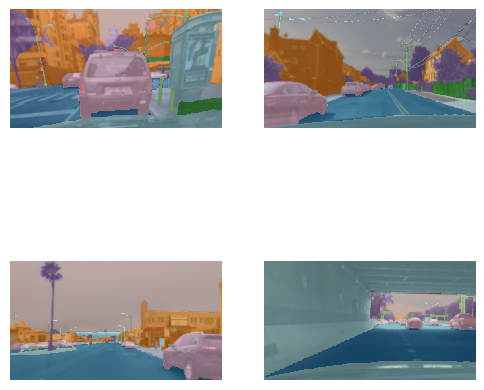

In [55]:
dls.show_batch()

In [56]:
from fastai.callback.wandb import WandbCallback

In [57]:
train_config = SimpleNamespace(
    framework="fastai",
    img_size=(180, 320),
    batch_size=8, # keep small in Colab to be manageable
    augment=True, # use data augmentation
    epochs=10, # for brevity, increase for better results :)
    data_split=0.7,
    lr=2e-3,
    pretrained=True  # whether to use pretrained encoder,
)

In [58]:
wandb.init(project=WANDB_PROJECT, job_type="train", config=train_config)

In [59]:
config = wandb.config

In [60]:
split_at = run.use_artifact(f'{SPLIT_DATA_AT}:latest')

dls = get_data(df, bs=config.batch_size, img_size=config.img_size, augment=config.augment)

In [61]:
learn = unet_learner(dls, arch=resnet18, pretrained=config.pretrained, cbs=SaveModelCallback()).to_fp16()

In [62]:
learn.fit_one_cycle(config.epochs, config.lr, cbs=[WandbCallback(log_preds=False, log_model=True)])

epoch,train_loss,valid_loss,time
0,3.103486,6.387717,00:03
1,3.158468,2.531167,00:02
2,3.424855,2.432950,00:02
3,2.994939,2.286152,00:02
4,2.683334,2.120654,00:02
5,2.479208,2.289975,00:02
6,2.334862,2.164847,00:02
7,2.222581,2.157053,00:02
8,2.121106,2.160498,00:02
9,2.045786,2.170073,00:02


Better model found at epoch 0 with valid_loss value: 6.387717247009277.
Better model found at epoch 1 with valid_loss value: 2.5311672687530518.
Better model found at epoch 2 with valid_loss value: 2.432950258255005.
Better model found at epoch 3 with valid_loss value: 2.286151885986328.
Better model found at epoch 4 with valid_loss value: 2.1206536293029785.


In [63]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_2,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▂▂▄▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
lr_1,▁▁▂▂▄▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
lr_2,▁▁▂▂▄▄▅▆▇███████▇▇▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁
mom_0,███▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇████
mom_1,███▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇████
mom_2,███▇▆▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇████
raw_loss,▃▃▃▂▃▄▅▂▂██▂▂▂▂▁▁▂▁▁▁▁▂▁▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂


# Step 4: Model Evaluation

Now that we have a trained model, we want to score it on the test data which was held out in step 2. This code is very similar to the training step, with the execption of slightly different naming. The important difference is that we load the saved model from the artifact. Note that the test predictions will be pretty weak if you're training on the TINY dataset for only one epoch :)

See a [live example in W&B](https://wandb.ai/stacey/dsviz-seg/artifacts/test_preds/test_preds_2ghlr3bh/b13a107bb3cb1e2a249c/files/test_results.table.json) of such test predictions.

In [64]:
test_dl = dls.test_dl(df_test, with_labels=True)

some utility funcs

In [65]:
inputs, predictions, targets, outputs = learn.get_preds(dl=test_dl, with_input=True, with_decoded=True)

inputs.shape, predictions.shape, outputs.shape, targets.shape

(torch.Size([10, 3, 180, 320]),
 torch.Size([10, 20, 180, 320]),
 torch.Size([10, 180, 320]),
 torch.Size([10, 180, 320]))

In [66]:
def faccuracy(inp, targ):
    "Foreground accuracy per item"
    return foreground_acc(inp.unsqueeze(0), targ.unsqueeze(0)).item()


def dice_per_class(inp, targ):
    "Compute dice per class"
    dice_scores = []
    eps = 1e-6
    for c in range(inp.shape[0]):
        dec_preds = inp.argmax(dim=0)
        p = torch.where(dec_preds == c, 1, 0)
        t = torch.where(targ == c, 1, 0)
        c_inter = (p * t).float().sum().item()
        c_union = (p + t).float().sum().item()
        if c_union:
            dice_scores.append(2.0 * c_inter / (c_union + eps))
        else:
            dice_scores.append(-1)
    return dice_scores

In [67]:
def create_row(sample, pred_label, prediction, class_labels):
    """"A simple function to create a row of (img, target, prediction, and scores...)"""
    (image, label) = sample
    # compute metrics
    dice_scores = dice_per_class(prediction, label)
    facc = faccuracy(prediction, label)
    image = image.permute(1, 2, 0)
    row =[wandb.Image(
                image,
                masks={
                    "predictions": {
                        "mask_data": pred_label[0].numpy(),
                        "class_labels": class_labels,
                    },
                    "ground_truths": {
                        "mask_data": label.numpy(),
                        "class_labels": class_labels,
                    },
                },
            ),
            *dice_scores,
            facc,
    ]
    return row

In [68]:
def create_dice_table(samples, outputs, predictions, class_labels):
    "Creates a wandb table with predictions and targets side by side"

    def _to_str(l):
        return [str(x) for x in l]
    
    items = list(zip(samples, outputs, predictions))
    
    table = wandb.Table(
        columns=["Image"]
        + _to_str(class_labels.values())
        + ["Foreground Acc"],
    )
    # we create one row per sample
    for item in progress_bar(items):
        table.add_data(*create_row(*item, class_labels=class_labels))
    
    return table

In [69]:
def get_predictions(learner, test_dl=None, max_n=None):
    """Return the samples = (x,y) and outputs (model predictions decoded), and predictions (raw preds)"""
    test_dl = learner.dls.valid if test_dl is None else test_dl
    inputs, predictions, targets, outputs = learner.get_preds(
        dl=test_dl, with_input=True, with_decoded=True
    )
    x, y, samples, outputs = learner.dls.valid.show_results(
        tuplify(inputs) + tuplify(targets), outputs, show=False, max_n=max_n
    )
    return samples, outputs, predictions

In [70]:
samples, outputs, predictions = get_predictions(learn, test_dl)

In [71]:
def table_from_dl(learn, test_dl, class_labels):
    samples, outputs, predictions = get_predictions(learn, test_dl)
    table = create_dice_table(samples, outputs, predictions, class_labels)
    return table

In [72]:
pred_table = table_from_dl(learn, test_dl, BDD_CLASSES)

In [73]:
wandb.init(project=WANDB_PROJECT, job_type="test")

# fetch the latest verstion of the training data
data_at = run.use_artifact(RAW_DATA_AT + ":latest")

In [74]:
test_res_at = wandb.Artifact("test_results_at", type="test_preds")

In [75]:
test_res_at.add(pred_table, "pred_table")

<ManifestEntry digest: 1P4XrG+gUy/uTivZzejMKw==>

In [76]:
wandb.log({"pred_table":pred_table})

In [77]:
wandb.log_artifact(test_res_at)

In [78]:
wandb.finish()

===================================
NOT DONE YET
====================================

# Step 5: Model Analysis

This is where it all comes together. In this step, we join the train and test scoring results with the original dataset and output corresponding artifacts. The new idea introduced here is a `wandb.JoinedTable` which allows you to join two `Table`s for further analysis in the UI.

[See a live example of all these tables](https://wandb.ai/stacey/dsviz-seg/artifacts/analysis/resnet_summary/b3054ed6229e43371365)

In [ ]:
with wandb.init(project=WANDB_PROJECT, job_type="analysis") as run:
    
    # Retrieve the original raw dataset
    dataset_artifact = run.use_artifact(RAW_DATA_AT + ":latest")
    data_table = dataset_artifact.get("raw_examples")
    
    # Retrieve the train and test score tables
    train_artifact = run.use_artifact("resnet_pred:latest")
    train_table = train_artifact.get("model_results")
    
    test_artifact = run.use_artifact("resnet_results:latest")
    test_table = test_artifact.get("model_test_results")
    
    # Join the tables on ID column and log them as outputs.
    train_results = wandb.JoinedTable(train_table, data_table, "id")
    test_results = wandb.JoinedTable(test_table, data_table, "id")
    
    artifact = wandb.Artifact("resnet_summary", "analysis")
    artifact.add(train_results, "train_results")
    artifact.add(test_results, "test_results")
    run.log_artifact(artifact)
    
    print("Saving data to WandB...")
print("... Run Complete")

### Review the model analysis in the Dashboard
Now, click on the above **Project** page (second link). This will look like the following:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/project_landing.png)

Click on the database icon, as previously, to see the artifacts. This time, you are seeing the artifacts for the entire project, with counts of their versions:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/many_artifact_types.png)

Go ahead and click the "`model`" artifact type, "Files", and "`model.pkl`". The viewer will provide different renderings based on the file type. For a pickled class, you get the following image. For deep networks saved as `.h5` files, you can see all the layers and their attributes.

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/model_view.png)

Next, head back to the artifact page, click Database type, expand `summary_results`, and select your most recent version. Click "Files" and select one of the join tables:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/pred_detail.png)

Zooming out a bit, you can toggle the bounding boxes, masks, group, filter, and sort the data:

![](https://raw.githubusercontent.com/staceysv/dsviz-demo/master/notebook_images/zoom_out_table.png)

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/grouped.png)

Finally, click graph view, and "explode". Now, you can visualize the entire process end-to-end:

![](https://raw.githubusercontent.com/wandb/dsviz-demo/master/notebook_images/summary_graph.png)